# FloodRisk – Top 9 Features + Custom ZZ Quantum Kernel
This notebook:
1. Loads the preprocessed flood dataset
2. Performs correlation analysis to select top 9 features
3. Uses a custom 9-qubit ZZ feature map with 3 encoding layers
4. Trains a quantum kernel SVM on 200 samples

In [1]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.9 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 2.2 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.1 MB 2.2 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.1 MB 2.7 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 2.9 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.1 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 3.3 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 3.5 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 3.6 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.5 MB/s  0:00:02

   ------------- -----------

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.transpiler import generate_preset_pass_manager

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load Data and Perform Correlation Analysis

In [3]:
# Load preprocessed flood dataset
df = pd.read_csv("flood_preprocessed.csv")

X = df.drop(columns=["FloodRisk"])
y = df["FloodRisk"].astype(int).values

print("Dataset loaded:")
print(f"  Rows: {len(df)}")
print(f"  Features: {X.shape[1]}")
print(f"  Class balance: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"\nFeature names: {list(X.columns)}")

Dataset loaded:
  Rows: 40000
  Features: 20
  Class balance: {np.int64(0): np.int64(691), np.int64(1): np.int64(38403), np.int64(2): np.int64(906)}

Feature names: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']


In [4]:
# Correlation analysis with target
# Calculate correlation of each feature with FloodRisk
correlations = X.corrwith(pd.Series(y, name='FloodRisk')).abs().sort_values(ascending=False)

print("Feature correlations with FloodRisk (sorted):")
print(correlations)

# Select top 9 features
top_9_features = correlations.head(9).index.tolist()

print(f"\n✓ Top 9 features selected:")
for i, feat in enumerate(top_9_features, 1):
    print(f"  {i}. {feat} (correlation: {correlations[feat]:.4f})")

Feature correlations with FloodRisk (sorted):
ClimateChange                      0.118121
PoliticalFactors                   0.117705
WetlandLoss                        0.114238
DamsQuality                        0.113647
Landslides                         0.113047
Watersheds                         0.111373
MonsoonIntensity                   0.110865
DeterioratingInfrastructure        0.109484
Encroachments                      0.108694
TopographyDrainage                 0.108290
IneffectiveDisasterPreparedness    0.107640
Urbanization                       0.107381
DrainageSystems                    0.106340
Siltation                          0.106121
InadequatePlanning                 0.105977
PopulationScore                    0.105574
RiverManagement                    0.105319
AgriculturalPractices              0.103906
Deforestation                      0.100594
CoastalVulnerability               0.093189
dtype: float64

✓ Top 9 features selected:
  1. ClimateChange (correlation

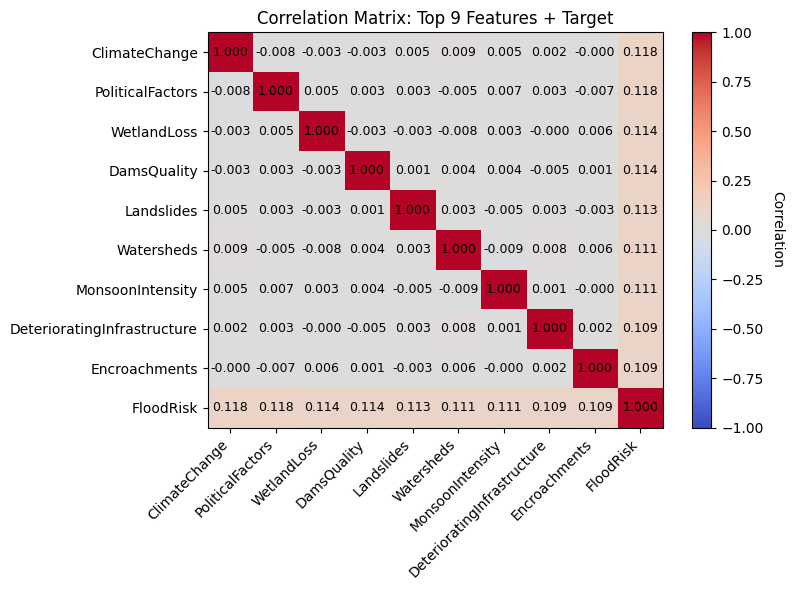

In [5]:
# Visualize correlation heatmap for top features
top_features_data = X[top_9_features].copy()
top_features_data['FloodRisk'] = y

# Compute correlation matrix
corr_matrix = top_features_data.corr()

# Create heatmap using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns)

# Add correlation values as text
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Correlation Matrix: Top 9 Features + Target')
plt.tight_layout()
plt.show()

## Step 2: Prepare Dataset with Top 9 Features

In [6]:
# Extract top 9 features
X_top9 = X[top_9_features].values

print(f"Selected feature matrix shape: {X_top9.shape}")

# Subsample to 100 samples (50 per class)
MAX_SAMPLES = 200

rng = np.random.default_rng(42)

idx0 = np.where(y == 0)[0]
idx1 = np.where(y == 1)[0]

n0 = min(len(idx0), MAX_SAMPLES // 2)
n1 = min(len(idx1), MAX_SAMPLES // 2)

sel0 = rng.choice(idx0, size=n0, replace=False)
sel1 = rng.choice(idx1, size=n1, replace=False)
sel = np.concatenate([sel0, sel1])
rng.shuffle(sel)

X_sampled = X_top9[sel]
y_sampled = y[sel]

print(f"\nSampled dataset: {X_sampled.shape}")
print(f"Class balance: {dict(zip(*np.unique(y_sampled, return_counts=True)))}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Selected feature matrix shape: (40000, 9)

Sampled dataset: (200, 9)
Class balance: {np.int64(0): np.int64(100), np.int64(1): np.int64(100)}

Train: (160, 9), Test: (40, 9)


In [7]:
# Scale features to [-π, π] for quantum encoding
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Clip to appropriate range for rotations
X_train_scaled = np.clip(X_train_scaled, -np.pi, np.pi)
X_test_scaled = np.clip(X_test_scaled, -np.pi, np.pi)

print("Features scaled for quantum encoding:")
print(f"  Mean: {X_train_scaled.mean(axis=0)}")
print(f"  Std: {X_train_scaled.std(axis=0)}")
print(f"  Range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

Features scaled for quantum encoding:
  Mean: [-7.35522754e-17  5.48866508e-16  2.47024623e-16  1.24900090e-16
 -1.19348975e-16 -2.99281606e-03 -5.23886490e-17 -3.74700271e-17
 -1.81799020e-16]
  Std: [1.         1.         1.         1.         1.         0.98982499
 1.         1.         1.        ]
  Range: [-2.313, 3.142]


## Step 3: Build Custom 9-Qubit ZZ Feature Map

In [8]:
# Custom 9-qubit ZZ Feature Map with Enhanced Entanglement
# ---------------------------------------------------------

# 1. Create parameters
x_params = [Parameter(f"x{i}") for i in range(9)]

feature_map = QuantumCircuit(9)

# 2. Hadamard layer
for i in range(9):
    feature_map.h(i)

# 3. First encoding layer: exp(i x_i Z_i)
for i in range(9):
    feature_map.rz(2 * x_params[i], i)

# 4. ZZ interaction blocks: exp(i x_i x_j Z_i Z_j)
#    implemented as: CNOT — RZ — CNOT
def zz_block(circuit, i, j, param):
    circuit.cx(i, j)
    circuit.rz(2 * param, j)
    circuit.cx(i, j)

def ryy_block(circuit, i, j, param):
    """RYY entanglement gate"""
    circuit.cx(i, j)
    circuit.ry(param, j)
    circuit.cx(i, j)

# First entanglement layer: Linear chain ZZ
for i in range(8):
    zz_block(feature_map, i, i+1, x_params[i] * x_params[i+1])

# Long-range ZZ entanglement
zz_block(feature_map, 0, 4, x_params[0] * x_params[4])
zz_block(feature_map, 1, 5, x_params[1] * x_params[5])
zz_block(feature_map, 2, 6, x_params[2] * x_params[6])
zz_block(feature_map, 3, 7, x_params[3] * x_params[7])
zz_block(feature_map, 4, 8, x_params[4] * x_params[8])

# Additional cross connections
zz_block(feature_map, 0, 8, x_params[0] * x_params[8])
zz_block(feature_map, 2, 5, x_params[2] * x_params[5])

# ===== SECOND ENCODING LAYER (Data Re-uploading) =====
# 5. Second Z rotation layer
for i in range(9):
    feature_map.rz(2 * x_params[i], i)

# 6. RYY entanglement blocks for more expressiveness
for i in range(8):
    ryy_block(feature_map, i, i+1, 2 * x_params[i] * x_params[i+1])

# More RYY long-range
ryy_block(feature_map, 0, 4, 2 * x_params[0] * x_params[4])
ryy_block(feature_map, 2, 7, 2 * x_params[2] * x_params[7])
ryy_block(feature_map, 1, 8, 2 * x_params[1] * x_params[8])

# ===== THIRD ENCODING LAYER (More Data Re-uploading) =====
# 7. Third Z rotation layer
for i in range(9):
    feature_map.rz(2 * x_params[i], i)

# 8. Additional ZZ blocks for even more entanglement
for i in range(0, 9, 2):
    if i+1 < 9:
        zz_block(feature_map, i, i+1, x_params[i] * x_params[i+1])

# Final cross-connections
zz_block(feature_map, 1, 6, x_params[1] * x_params[6])
zz_block(feature_map, 3, 8, x_params[3] * x_params[8])


print("✓ Enhanced 9-qubit feature map built (3 encoding layers)")
print(f"  Parameters: {len(feature_map.parameters)}")
print(f"  Depth: {feature_map.depth()}")
print(f"  Gates: {len(feature_map.data)}")
print("\nCircuit diagram:")
print(feature_map.draw('text'))


✓ Enhanced 9-qubit feature map built (3 encoding layers)
  Parameters: 9
  Depth: 67
  Gates: 132

Circuit diagram:
     ┌───┐┌──────────┐                                                       »
q_0: ┤ H ├┤ Rz(2*x0) ├──■───────────────────■────────────────────────────────»
     ├───┤├──────────┤┌─┴─┐┌─────────────┐┌─┴─┐                              »
q_1: ┤ H ├┤ Rz(2*x1) ├┤ X ├┤ Rz(2*x0*x1) ├┤ X ├──■───────────────────■───────»
     ├───┤├──────────┤└───┘└─────────────┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐     »
q_2: ┤ H ├┤ Rz(2*x2) ├─────────────────────────┤ X ├┤ Rz(2*x1*x2) ├┤ X ├──■──»
     ├───┤├──────────┤                         └───┘└─────────────┘└───┘┌─┴─┐»
q_3: ┤ H ├┤ Rz(2*x3) ├──────────────────────────────────────────────────┤ X ├»
     ├───┤├──────────┤                                                  └───┘»
q_4: ┤ H ├┤ Rz(2*x4) ├───────────────────────────────────────────────────────»
     ├───┤├──────────┤                                                       »
q_5: ┤ H ├┤ Rz(

## Step 4: Build Quantum Kernel (Compute-Uncompute)

In [9]:
# Setup backend and sampler
backend = AerSimulator(method="statevector")
sampler = Sampler(backend_options={"method": "statevector"})

print("✓ Backend and sampler ready")
print(f"  Feature map depth: {feature_map.depth()}")
print(f"  Feature map gates: {len(feature_map.data)}")

✓ Backend and sampler ready
  Feature map depth: 67
  Feature map gates: 132


In [10]:
# Kernel computation functions

def bind_params(circ: QuantumCircuit, values: np.ndarray) -> QuantumCircuit:
    """Bind x0..x8 to circuit parameters."""
    if len(values) != 9:
        raise ValueError(f"Expected 9 features, got {len(values)}.")
    return circ.assign_parameters(
        {x_params[i]: float(values[i]) for i in range(9)}, 
        inplace=False
    )

def compute_uncompute_circuit(xv, yv):
    """Build U(x) · U(y)†, then measure all qubits."""
    # Bind parameters BEFORE composing (parameters must be bound to original circuit)
    u_x = bind_params(feature_map, xv)
    u_y_dag = bind_params(feature_map, yv).inverse()
    
    qc = QuantumCircuit(9)
    qc.compose(u_x, inplace=True)
    qc.compose(u_y_dag, inplace=True)
    qc.measure_all()
    return qc

def prob_all_zero(quasi_dist):
    """Return P(|000000000>) from quasi distribution."""
    # QuasiDistribution uses integer keys: 0 = all zeros bitstring
    return float(quasi_dist.get(0, 0.0))

def kernel_matrix(X1, X2, batch_size=64, symmetric=False):
    """Compute kernel matrix K[i,j] = |<phi(x_i)|phi(x_j)>|^2."""
    X1 = np.asarray(X1, dtype=float)
    X2 = np.asarray(X2, dtype=float)
    K = np.zeros((len(X1), len(X2)), dtype=float)

    if symmetric:
        # Compute upper triangle then mirror
        for i in range(len(X1)):
            circuits, js = [], []
            for j in range(i, len(X2)):
                circuits.append(compute_uncompute_circuit(X1[i], X2[j]))
                js.append(j)
                if len(circuits) == batch_size:
                    res = sampler.run(circuits).result()
                    for k, jj in enumerate(js):
                        K[i, jj] = prob_all_zero(res.quasi_dists[k])
                    circuits, js = [], []
            if circuits:
                res = sampler.run(circuits).result()
                for k, jj in enumerate(js):
                    K[i, jj] = prob_all_zero(res.quasi_dists[k])
        # Mirror
        for i in range(len(X1)):
            for j in range(i):
                K[i, j] = K[j, i]
    else:
        for i in range(len(X1)):
            circuits, js = [], []
            for j in range(len(X2)):
                circuits.append(compute_uncompute_circuit(X1[i], X2[j]))
                js.append(j)
                if len(circuits) == batch_size:
                    res = sampler.run(circuits).result()
                    for k, jj in enumerate(js):
                        K[i, jj] = prob_all_zero(res.quasi_dists[k])
                    circuits, js = [], []
            if circuits:
                res = sampler.run(circuits).result()
                for k, jj in enumerate(js):
                    K[i, jj] = prob_all_zero(res.quasi_dists[k])

    return K

print("✓ Kernel computation functions ready")

✓ Kernel computation functions ready


## Step 5: Train Quantum Kernel SVM

In [1]:
# Debug: test a single kernel computation
print("Debug: Testing single kernel computation...")
test_circuit = compute_uncompute_circuit(X_train_scaled[0], X_train_scaled[0])
print(f"Circuit has {test_circuit.num_qubits} qubits")
print(f"Circuit has {len(test_circuit.data)} operations")

# Run and check result
test_result = sampler.run([test_circuit]).result()
test_dist = test_result.quasi_dists[0]
print(f"\nQuasi-distribution keys: {list(test_dist.keys())[:10]}")
print(f"Number of outcomes: {len(test_dist)}")
print(f"P(all zeros): {prob_all_zero(test_dist):.6f}")
print(f"Top 5 outcomes:")
for outcome, prob in sorted(test_dist.items(), key=lambda x: -x[1])[:5]:
    print(f"  {outcome}: {prob:.6f}")

# Compute training kernel
import time

print("\nComputing K_train (9-qubit enhanced kernel)...")
start_time = time.time()
K_train = kernel_matrix(X_train_scaled, X_train_scaled, batch_size=64, symmetric=True)
kernel_train_time = time.time() - start_time

print(f"\nKernel matrix statistics:")

print(f"  Shape: {K_train.shape}")
print(f"  ⏱️  Computation time: {kernel_train_time:.2f} seconds")

print(f"  Range: [{K_train.min():.4f}, {K_train.max():.4f}]")
print(f"  Diagonal mean: {np.diag(K_train).mean():.4f}")
print(f"  Mean: {K_train.mean():.4f}")

Debug: Testing single kernel computation...


NameError: name 'compute_uncompute_circuit' is not defined

In [ ]:
# Train SVM with different C values
best_acc = 0
best_C = 1.0
best_model = None
best_y_pred = None

C_values = [0.1, 1.0, 10.0, 100.0, 1000.0]

print("Computing K_test...")
start_time = time.time()
K_test = kernel_matrix(X_test_scaled, X_train_scaled, batch_size=64, symmetric=False)
kernel_test_time = time.time() - start_time
print(f"  ⏱️  K_test computation time: {kernel_test_time:.2f} seconds")

print("\nTuning SVC hyperparameter C...")
training_start = time.time()
for C in C_values:
    svc = SVC(kernel="precomputed", C=C, class_weight='balanced')
    svc.fit(K_train, y_train)
    
    y_pred = svc.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"  C={C:7.1f}: Accuracy = {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_model = svc
        best_y_pred = y_pred

training_time = time.time() - training_start

print("\n" + "="*70)
print(f"🎯 BEST MODEL ACCURACY: {best_acc:.4f}")
print(f"   Best C: {best_C}")
print(f"   Features used: {top_9_features}")
print(f"   ⏱️  Training time: {training_time:.2f} seconds")
print(f"   ⏱️  Total quantum computation time: {kernel_train_time + kernel_test_time:.2f} seconds")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_test, best_y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_y_pred))

Computing K_test...


## Step 6: Visualize Results

In [ ]:
# Visualize kernel matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Kernel heatmap
im = axes[0].imshow(K_train, cmap='viridis', aspect='auto')
axes[0].set_title('Training Kernel Matrix')
axes[0].set_xlabel('Sample index')
axes[0].set_ylabel('Sample index')
plt.colorbar(im, ax=axes[0], label='Kernel value')

# Kernel value distribution
axes[1].hist(K_train.flatten(), bins=50, edgecolor='black')
axes[1].set_xlabel('Kernel value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Kernel Values')

# Class-separated kernel values
idx_class_0 = np.where(y_train == 0)[0]
idx_class_1 = np.where(y_train == 1)[0]

within_0 = K_train[np.ix_(idx_class_0, idx_class_0)].flatten()
within_1 = K_train[np.ix_(idx_class_1, idx_class_1)].flatten()
between = K_train[np.ix_(idx_class_0, idx_class_1)].flatten()

axes[2].hist(within_0, bins=30, alpha=0.5, label='Within class 0', edgecolor='black')
axes[2].hist(within_1, bins=30, alpha=0.5, label='Within class 1', edgecolor='black')
axes[2].hist(between, bins=30, alpha=0.5, label='Between classes', edgecolor='black')
axes[2].set_xlabel('Kernel value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Kernel Values by Class')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Feature space visualization (2D projections)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First two features
axes[0].scatter(X_sampled[:, 0], X_sampled[:, 1], c=y_sampled, cmap='coolwarm', alpha=0.7, s=30)
axes[0].set_xlabel(f'{top_9_features[0]}')
axes[0].set_ylabel(f'{top_9_features[1]}')
axes[0].set_title(f'Feature Space: {top_9_features[0]} vs {top_9_features[1]}')
axes[0].grid(alpha=0.3)

# Last two features
axes[1].scatter(X_sampled[:, 2], X_sampled[:, 3], c=y_sampled, cmap='coolwarm', alpha=0.7, s=30)
axes[1].set_xlabel(f'{top_9_features[2]}')
axes[1].set_ylabel(f'{top_9_features[3]}')
axes[1].set_title(f'Feature Space: {top_9_features[2]} vs {top_9_features[3]}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates:
1. **Feature Selection**: Using correlation analysis to identify the most relevant features
2. **Custom Quantum Circuit**: Hand-crafted 9-qubit ZZ feature map with linear + long-range entanglement
3. **Quantum Kernel Method**: Compute-uncompute approach for kernel estimation
4. **Classification**: SVM with precomputed quantum kernel

The custom ZZ feature map provides a controlled way to encode classical data into quantum states with well-understood entanglement patterns.